# Diagnose and Probe an Image Classifier

Today we'll:

- Look at the images that have the highest loss (does that necessarily mean that the classifier got them wrong?)
- Run the output layer (the linear classifier) by hand to see how to interpret it as comparing features with prototypes for each class.
- Compute the cross-entropy loss by hand and check if we match Keras's output.

## Setup

In [1]:
# Check versions of Keras and Tensorflow
!pip list | egrep 'keras|tensorflow $'

keras                                    2.15.0
keras-core                               0.1.7
keras-cv                                 0.8.1
keras-nlp                                0.7.0
keras-tuner                              1.4.6


In [2]:
import os
# Results are better with the TensorFlow backend; this is probably a bug in Keras 3 but I haven't tracked it down.
os.environ["KERAS_BACKEND"] = "tensorflow"

from IPython.display import display, HTML
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import keras
import keras_cv
import tensorflow as tf
import tensorflow_datasets as tfds
print(f"Keras version: {keras.__version__}, backend: {keras.backend.backend()}")
num_gpus = len(tf.config.list_physical_devices('GPU'))
print(f"GPUs: {num_gpus}")
if num_gpus == 0:
    display(HTML("No GPUs available. Training will be slow. <b>Please enable an accelerator.</b>"))

2024-02-23 16:54:28.065415: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 16:54:28.065528: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 16:54:28.223969: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using TensorFlow backend
Keras version: 2.15.0, backend: tensorflow
GPUs: 1


In [3]:
def show_image_grid(images, titles=None, rows=None, cols=3, title_fontsize=8, figsize=(10, 10)):
    if rows is None:
        rows = (len(images) + (cols - 1)) // cols

    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    for ax in axs.flatten(): ax.axis('off')
    for i, ax in enumerate(axs.flatten()):
        if i >= len(images): break
        ax.imshow(np.array(images[i]).astype('uint8'))
        if titles is not None:
            ax.set_title(titles[i], fontsize=title_fontsize)

def get_images_from_dataset(dataset, indices):
    if hasattr(dataset, 'file_paths'):
        # FIXME: hardcoded options
        img_loader_opts = dict(target_size=(256, 256), keep_aspect_ratio=True)
        items_by_idx = {idx: keras.utils.load_img(dataset.file_paths[idx], **img_loader_opts) for idx in indices}
    else:
        items_by_idx = {idx: item for idx, (item, label) in enumerate(dataset.unbatch()) if idx in indices}
    return [items_by_idx[idx] for idx in indices]    


## Configure our experiments

In [4]:
class config:
    seed = 123
    learning_rate = 1e-3
    epochs = 1
    batch_size = 16
    image_size = (256, 256)
    model_preset = "mobilenet_v3_large_imagenet"

In [5]:
# Reproducibility
# See https://keras.io/examples/keras_recipes/reproducibility_recipes/
#
# Set a seed so that the results are the same every time this is run.
keras.utils.set_random_seed(config.seed)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
tf.config.experimental.enable_op_determinism()

### Load the data

We'll use a dataset of flower images for this example, but you can later switch this out for another dataset as long as you keep the file-and-folder structure.

The details of the code in this section are not important at this time; just run these cells.

In [6]:
path_to_downloaded_file = keras.utils.get_file(
    origin="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
    extract=True,
)

228813984/228813984 [==============================] - 1s 0us/step


Let's see what just got downloaded.

In [7]:
data_path = Path(path_to_downloaded_file).parent / 'flower_photos'
!ls {data_path}

LICENSE.txt  daisy  dandelion  roses  sunflowers  tulips


We'll use a Keras helper function to load the data.

Docs: https://keras.io/api/data_loading/image/#imagedatasetfromdirectory-function

In [8]:
# Define which classes we want to use, in what order.
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# Create training and validation datasets
train_dataset, val_dataset = keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    labels='inferred',
    class_names=class_names,
    label_mode='int',
    batch_size=config.batch_size,
    image_size=config.image_size,
    shuffle=True,
    seed=128,
    subset='both',
    crop_to_aspect_ratio=True   
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Using 734 files for validation.


Let's show some example images.

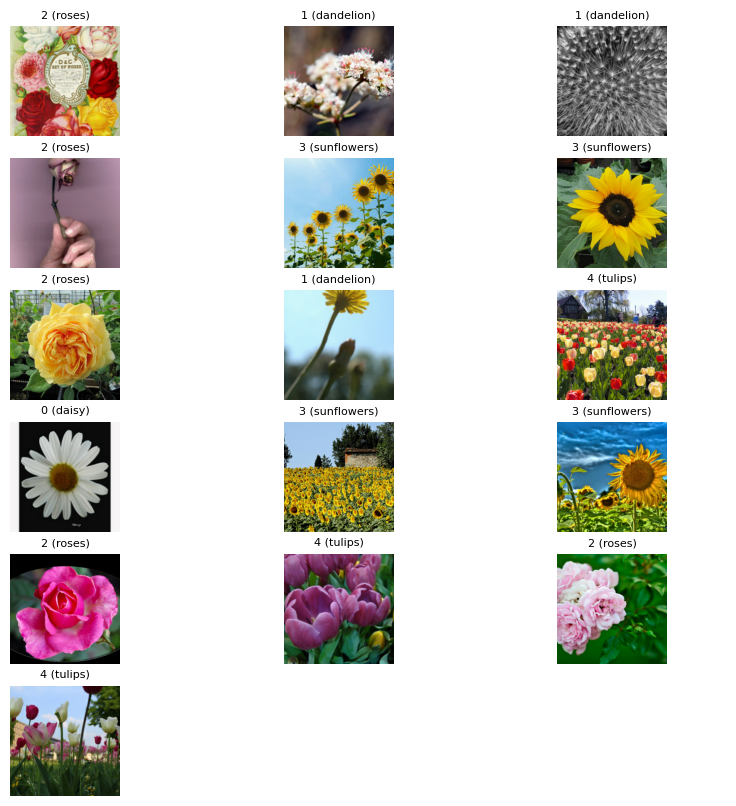

In [9]:
[[example_images, example_labels]] = train_dataset.take(1)
show_image_grid(
    example_images,
    titles=[f"{label} ({class_names[label]})" for label in example_labels])

### Train a model

In [10]:
# Create a model using a pretrained backbone
# See https://keras.io/api/keras_cv/models/tasks/image_classifier/ for options
model = keras_cv.models.ImageClassifier.from_preset(
    config.model_preset,
    num_classes=len(class_names))

# Freeze the feature extractor so it doesn't get updated during training
model.backbone.trainable = False

# Set up the model for training
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=config.learning_rate),
    metrics=['accuracy']
)
model.summary(show_trainable=True)

# Train the model. (Note: this may show some warnings, and it may stop without showing
# progress for up to a minute while it translates the model to run on the GPU.)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=config.epochs
)

Attaching 'config.json' from model 'keras/mobilenetv3/keras/mobilenet_v3_large_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/mobilenetv3/keras/mobilenet_v3_large_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/mobilenetv3/keras/mobilenet_v3_large_imagenet/2' to your Kaggle notebook...
/opt/conda/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/opt/conda/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


Model: "image_classifier"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_1 (InputLayer)        [(None, None, None, 3)]   0         N          
                                                                            
 mobile_net_v3_large_backbo  (None, None, None, 960)   2996352   N          
 ne (MobileNetV3Backbone)                                                   
                                                                            
 avg_pool (GlobalAveragePoo  (None, 960)               0         Y          
 ling2D)                                                                    
                                                                            
 predictions (Dense)         (None, 5)                 4805      Y          
                                                                            
Total params: 3001157 (11.45 MB)
Trainable params:

I0000 00:00:1708707309.627152     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


184/184 [==============================] - 14s 38ms/step - loss: 0.5712 - accuracy: 0.7990 - val_loss: 0.4086 - val_accuracy: 0.8624


# Top Losses

The following code will compute the model's predictions on the validation set and extract the corresponding correct labels. We'll use this to compute the loss for each image.

In [11]:
val_predicted_probs = model.predict(val_dataset)
val_predicted_probs.shape

46/46 [==============================] - 2s 20ms/step


(734, 5)

**Quick Check**: what do the two numbers in that shape mean?

734 is the input and the 5 is the number of types of flowers

In [12]:
# Get the labels from the dataset (to check whether the model got them right)
val_labels = [int(label) for img, label in val_dataset.unbatch()]

In [13]:
# compute loss for each sample
loss_func = keras.losses.SparseCategoricalCrossentropy(reduction=keras.losses.Reduction.NONE)
val_losses = loss_func(val_labels, val_predicted_probs).numpy()

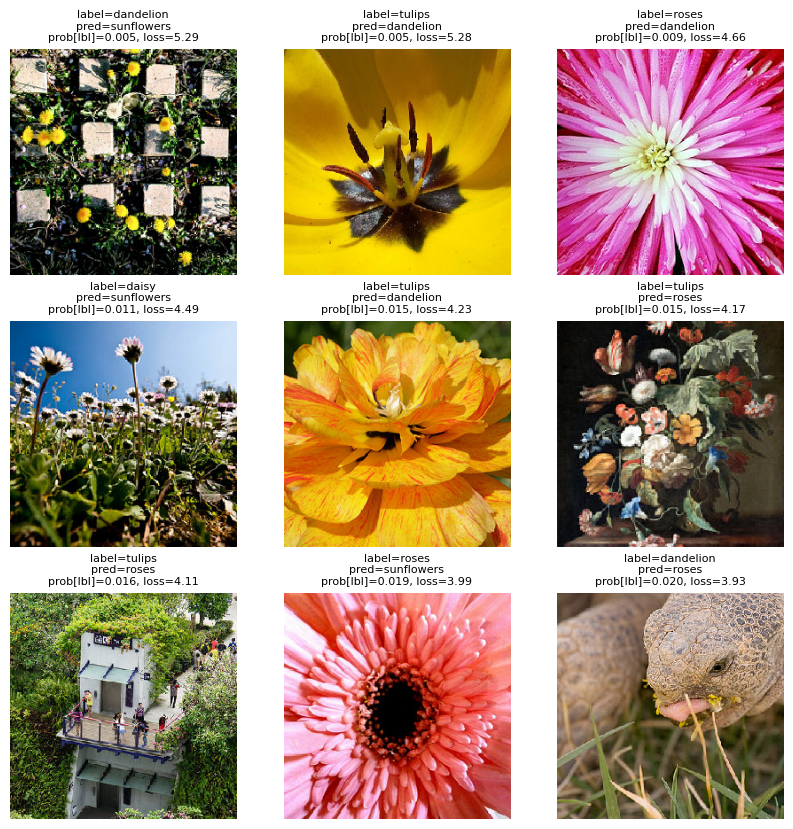

In [14]:
def plot_top_losses(dataset, predictions, losses, labels, class_names, n=9, **kw):
    top_n_indices = np.argsort(losses)[-n:][::-1].tolist()
    titles = []
    for idx in top_n_indices:
        label = labels[idx]
        pred = predictions[idx]
        titles.append(f"label={class_names[label]}\npred={class_names[np.argmax(pred)]}\nprob[lbl]={pred[label]:.3f}, loss={losses[idx]:.2f}")
    images = get_images_from_dataset(dataset, top_n_indices)
    show_image_grid(images, titles, **kw)

plot_top_losses(val_dataset, val_predicted_probs, val_losses, val_labels, class_names, n=9)

**Observations**

1. What trend do you observe about the `loss` values shown above the images, as you move from top left to bottom right?

2. What trend do you observe about the `pred[label]` values shown?

3. *added later*: If you know flowers: were the labels correct? Could the loss help us identidy mis-labeled images?

4. Compute the cross-entropy loss for the bottom-right image by hand and check if it matches the `loss` value shown. (*Note*: Keras uses log base e, i.e., the "natural" logarithm, `ln`)



5. Could an image show up on this grid if it was classified correctly? Why or why not? (Try passing `n=100` and `figsize=(30, 20)`)

1. The losses decrease.
2. They have the names of the flowers that they predict.
3. I don't know flowers.
4. -ln(.111)
5. Yes, it could show up it would just have to have a high amount of loss meaning that it would have to be very uncertain.

# Manual Last Layer

We'll now run the last layer of the model by hand to see how it compares features with prototypes for each class.

The following code will compute the outputs of the feature extractor (the input to the last layer of the model) for all of the images in the validation set.

In [15]:
last_linear_layer = model.layers[-1]
feature_extractor = keras.Model(inputs=model.inputs, outputs=last_linear_layer.input)
val_features = feature_extractor.predict(val_dataset)
print("\nvalidation features shape:", val_features.shape)

46/46 [==============================] - 2s 19ms/step

validation features shape: (734, 960)


**Observe**

1. What do those two numbers in the shape mean?
2. How many features did the feature extractor produce for each image?

1. 784 is the input the number of images, the 1280 is the number of features
2. 1280

The following code will extract the weights and biases of the last layer of the model.

In [16]:
weights, bias = last_linear_layer.get_weights()
print("weights shape:", weights.shape)
print("bias shape:", bias.shape)

weights shape: (960, 5)
bias shape: (5,)


*Observe*: 

1. How does the shape of `weights` compare to your answer to the previous question?
2. How many parameters does this layer have? Check your answer against the summary table that Keras showed when you trained the model. (The last entry inside the table represents this layer.)

1. the number of features gets put into the number of types of the flowers
2. 6405

As we discussed in class, we can interpret the columns of `weights` as "prototypes" for each class. Since we're now working in thousands of dimensions, we can't visualize these prototypes directly. But we can visualize them in terms of what images are aligned with them.

Let's start by extracting the prototype for one class. Quick NumPy reference:

- Extract a row of an array: `arr[i]`
- Extract a column of an array: `arr[:, j]`

**Exercise**: Extract the prototype for the "rose" class. Check the shape of the resulting array!

In [17]:
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [18]:
rose_class_index = 2
rose_prototype = weights[:, rose_class_index]
rose_prototype.shape

(960,)

Now let's compute how much each image in the validation set aligns with this prototype. We'll do this by computing the dot product between the prototype and the feature vector for each image.

In [19]:
rose_scores = [
  feature_vec @ rose_prototype
  for feature_vec in val_features
]

This is actually exactly the same as the dot product of the feature array with the rose prototype vector:

In [20]:
rose_scores = val_features @ rose_prototype
rose_scores.shape

(734,)

We'll use `np.argsort` to find the images that have the highest and lowest scores. We'll identify an image by its *index* in the validation set.

In [21]:
images_by_rosiness = np.argsort(rose_scores)
print("images_by_rosiness shape:", images_by_rosiness.shape)
print("Least rosy image:", images_by_rosiness[0])
print("Rosiest image:", images_by_rosiness[-1])

images_by_rosiness shape: (734,)
Least rosy image: 155
Rosiest image: 541


Now, show the rosiest images (note that `[::-1]` is a Python idiom to reverse a list).

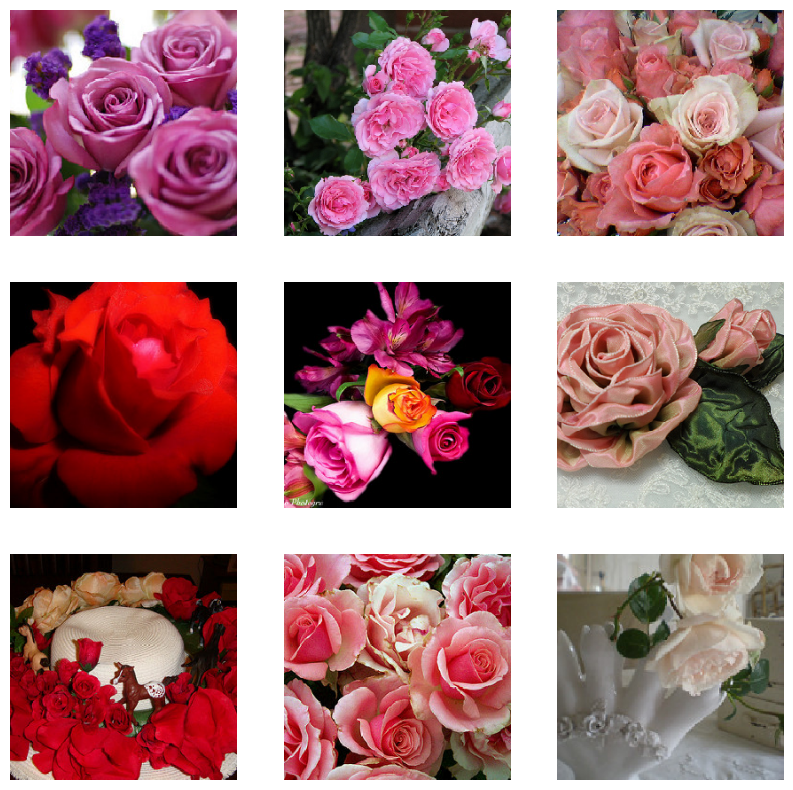

In [22]:
show_image_grid(
  get_images_from_dataset(
    val_dataset, images_by_rosiness[::-1][:9]))

**Exercise**: Show the least rosy images.

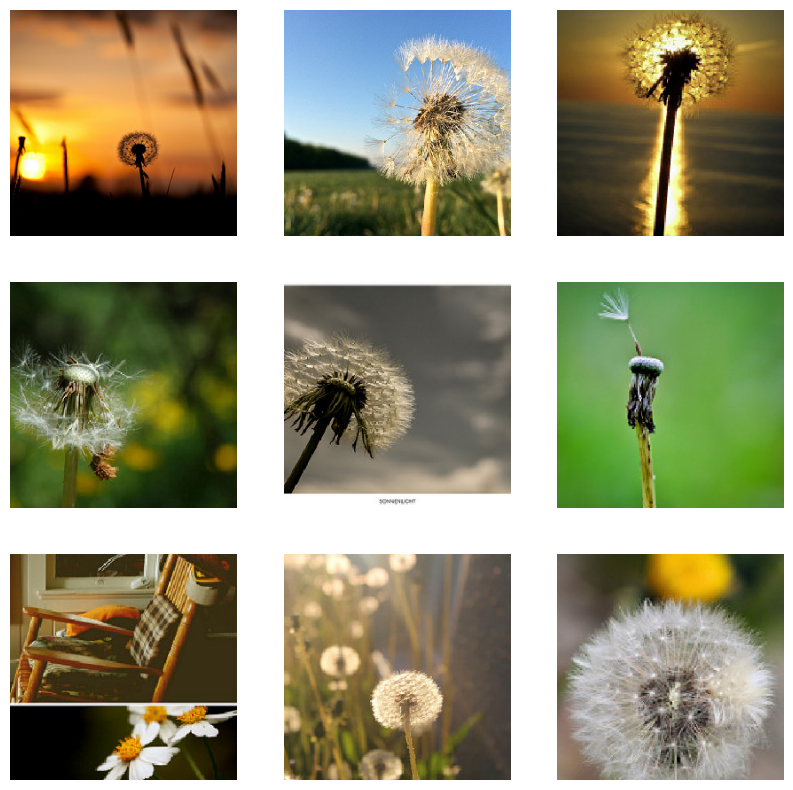

In [23]:
show_image_grid(
  get_images_from_dataset(
    val_dataset, images_by_rosiness[::1][:9]))

Now, let's do this for all of the classes. We could loop over all of the classes and do the dot products above...or we could realize that this is **exactly what the matrix multiplication** of the feature array with the weights matrix does!

In [24]:
print("Features matrix shape:", val_features.shape)
print("Weights shape:", weights.shape)

# Compute the logits by a forward pass through the linear layer
# using the validation features (val_features), weights, and bias
logits = val_features @ weights + bias
print("Logits shape:", logits.shape)

Features matrix shape: (734, 960)
Weights shape: (960, 5)
Logits shape: (734, 5)


## Softmax and Cross-Entropy

The last steps in doing by hand what Keras was doing for us are:

1. Apply softmax to get the predicted probabilities
2. Compute the cross-entropy loss

Let's do each of those.

First, softmax. For numerical stability, we subtract the maximum value from each row before taking the exponentials. This doesn't change the result -- *think about why*. Then fill in the missing code to compute the softmax.

In [25]:
logits -= np.max(logits, axis=1, keepdims=True)
exp_logits = np.exp(logits)
sum_exp_logits = np.sum(exp_logits, axis=1, keepdims=True)
val_predicted_probs_manual = exp_logits / sum_exp_logits

In [26]:
assert np.allclose(val_predicted_probs, val_predicted_probs_manual, atol=1e-3)

Now the cross-entropy. To get the negative log of the predicted probability for the correct class, we'll first compute the negative log of *all* of the predicted probabilities, then multiply by the one-hot encoded correct labels. Fill in the missing code to compute the cross-entropy loss.

In [27]:
logprobs = np.log(val_predicted_probs_manual)
print("logprobs shape:", logprobs.shape) # num images by num classes
one_hot_labels = keras.utils.to_categorical(val_labels, num_classes=len(class_names)) # num images by num classes

loss_per_sample = -np.sum(one_hot_labels * logprobs, axis=1)

logprobs shape: (734, 5)


Now find the average of the cross-entropy loss for the entire validation set (using `np.mean`). Does it match the loss that Keras computed for us during training?

Yes

In [28]:
np.mean(loss_per_sample)

0.40857238

# Reflection

I needed to change the model_preset variable to something else.

I learned that different backbones can have different intital starting spot. The shapes have different shapes meaning the different models have different embedding spaces.